<a href="https://colab.research.google.com/github/ishandahal/Repo_Torch/blob/master/Torch_Barebones_Api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Testing different level APIs of Torch

##Getting required packages for the data to be utilized (CIFAR10)

In [36]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-jv8hth0x
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-jv8hth0x
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10323 sha256=5a020457fdd7f1a96fd809c3d8be9e8f3992d202a95af5ef49a7338129cc847e
  Stored in directory: /tmp/pip-ephem-wheel-cache-l0_zl6qy/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


##Setup code 

In [37]:
import coutils
from coutils import fix_random_seed

from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [38]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## If GPU is available, it will be used if not fall back is on CPU


In [39]:
dtype = torch.float32
ltype = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda:0


In [40]:
### Defining flatten function for convenience
def flatten(x, start_dim=1, end_dim=-1):
  return x.flatten(start_dim=start_dim, end_dim=end_dim)

## Barebones PyTorch for a two layered network.

In [41]:
def two_layer_fc(x, params):
  """
  A fully-connected neural networks; the architecture is:
  NN is fully connected -> ReLU -> fully connected layer.
  Note that this function only defines the forward pass; 
  PyTorch will take care of the backward pass for us.
  
  The input to the network will be a minibatch of data, of shape
  (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
  and the output layer will produce scores for C classes.
  
  Inputs:
  - x: A PyTorch Tensor of shape (N, d1, ..., dM) giving a minibatch of
    input data.
  - params: A list [w1, w2] of PyTorch Tensors giving weights for the network;
    w1 has shape (H, D) and w2 has shape (C, H).
  
  Returns:
  - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
    the input data x.
  """
  # first we flatten the image
  x = flatten(x)  # shape: [batch_size, C x H x W]
  
  w1, b1, w2, b2 = params
  
  # Forward pass: compute predicted y using operations on Tensors. Since w1 and
  # w2 have requires_grad=True, operations involving these Tensors will cause
  # PyTorch to build a computational graph, allowing automatic computation of
  # gradients. Since we are no longer implementing the backward pass by hand we
  # don't need to keep references to intermediate values.
  # Note that F.linear(x, w, b) is equivalent to x.mm(w.t()) + b
  # For ReLU, you can also use `.clamp(min=0)`, equivalent to `F.relu()`

  x = F.relu(F.linear(x, w1, b1))
  x = F.linear(x, w2, b2)
  return x
    

def two_layer_fc_test():
  hidden_layer_size = 42
  x = torch.zeros((64, 3, 16, 16), dtype=dtype)  # minibatch size 64, feature dimension 3*16*16
  w1 = torch.zeros((hidden_layer_size, 3*16*16), dtype=dtype)
  b1 = torch.zeros((hidden_layer_size,), dtype=dtype)
  w2 = torch.zeros((10, hidden_layer_size), dtype=dtype)
  b2 = torch.zeros((10,), dtype=dtype)
  scores = two_layer_fc(x, [w1, b1, w2, b2])
  print('Output size:', list(scores.size()))  # you should see [64, 10]

two_layer_fc_test()

Output size: [64, 10]


#Barebones three layered Conv-net.

In [42]:
def three_layer_convnet(x, params):
  """
  Performs the forward pass of a three-layer convolutional network with the
  architecture defined above.

  Inputs:
  - x: A PyTorch Tensor of shape (N, C, H, W) giving a minibatch of images
  - params: A list of PyTorch Tensors giving the weights and biases for the
    network; should contain the following:
    - conv_w1: PyTorch Tensor of shape (channel_1, C, KH1, KW1) giving weights
      for the first convolutional layer
    - conv_b1: PyTorch Tensor of shape (channel_1,) giving biases for the first
      convolutional layer
    - conv_w2: PyTorch Tensor of shape (channel_2, channel_1, KH2, KW2) giving
      weights for the second convolutional layer
    - conv_b2: PyTorch Tensor of shape (channel_2,) giving biases for the second
      convolutional layer
    - fc_w: PyTorch Tensor giving weights for the fully-connected layer. Can you
      figure out what the shape should be?
    - fc_b: PyTorch Tensor giving biases for the fully-connected layer. Can you
      figure out what the shape should be?
  
  Returns:
  - scores: PyTorch Tensor of shape (N, C) giving classification scores for x
  """
  conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
  scores = None
  
  x = F.relu(F.conv2d(x, conv_w1, bias=conv_b1, padding=2))
  x = F.relu(F.conv2d(x, conv_w2, bias=conv_b2, padding=1))
  x = flatten(x)
  scores = F.linear(x, fc_w, fc_b) ##shape of w = C, ch_2*32*32, b=C

  return scores

In [43]:
def three_layer_convnet_test():
  x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]

  conv_w1 = torch.zeros((6, 3, 5, 5), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
  conv_b1 = torch.zeros((6,))  # out_channel
  conv_w2 = torch.zeros((9, 6, 3, 3), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
  conv_b2 = torch.zeros((9,))  # out_channel

  # you must calculate the shape of the tensor after two conv layers, before the fully-connected layer
  fc_w = torch.zeros((10, 9 * 32 * 32))
  fc_b = torch.zeros(10)

  scores = three_layer_convnet(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
  print('Output size:', list(scores.size()))  # you should see [64, 10]
three_layer_convnet_test()

Output size: [64, 10]


##Kaiming Initialization 
Using Kaiming initialization for the weights


In [44]:
fix_random_seed(0)

# Create a weight of shape [3 x 5]
print(nn.init.kaiming_normal_(torch.empty(3, 5, dtype=dtype, device=device)))
print(nn.init.zeros_(torch.empty(3, 5, dtype=dtype, device=device)))

tensor([[-0.5848, -0.2690, -1.6721,  0.0918, -0.0764],
        [-0.3667, -0.3939, -0.2077, -0.6796, -0.2297],
        [-1.0569,  1.4328,  0.1971, -0.1165,  0.8137]], device='cuda:0')
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0')


###Method to check the accuracy of our models.
Note: Whenc checking for accuracy gradients do not need to be calculated. In order to prevent the computational graph from being built we specify `torch.no_grad()`


In [45]:
def check_accuracy_part2(loader, model_fn, params):
  """
  Check the accuracy of a classification model.
  
  Inputs:
  - loader: A DataLoader for the data split we want to check
  - model_fn: A function that performs the forward pass of the model,
    with the signature scores = model_fn(x, params)
  - params: List of PyTorch Tensors giving parameters of the model
  
  Returns: Nothing, but prints the accuracy of the model
  """
  split = 'val' if loader.dataset.train else 'test'
  print('Checking accuracy on the %s set' % split)
  num_correct, num_samples = 0, 0
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=ltype)
      scores = model_fn(x, params)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

###Barebones Pytorch: Training loop
Basic training loop using stocastic gradiant descent wothout momentum. We will use `torch.nn.functional.cross_entropy` to compute the loss. 

In [46]:
def train_part2(model_fn, params, learning_rate):
  """
  Train a model on CIFAR-10.
  
  Inputs:
  - model_fn: A Python function that performs the forward pass of the model.
    It should have the signature scores = model_fn(x, params) where x is a
    PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
    model weights, and scores is a PyTorch Tensor of shape (N, C) giving
    scores for the elements in x.
  - params: List of PyTorch Tensors giving weights for the model
  - learning_rate: Python scalar giving the learning rate to use for SGD
  
  Returns: Nothing
  """
  for t, (x, y) in enumerate(loader_train):
    # Move the data to the proper device (GPU or CPU)
    x = x.to(device=device, dtype=dtype)
    y = y.to(device=device, dtype=ltype)

    # Forward pass: compute scores and loss
    scores = model_fn(x, params)
    loss = F.cross_entropy(scores, y)

    # Backward pass: PyTorch figures out which Tensors in the computational
    # graph has requires_grad=True and uses backpropagation to compute the
    # gradient of the loss with respect to these Tensors, and stores the
    # gradients in the .grad attribute of each Tensor.
    loss.backward()

    # Update parameters. We don't want to backpropagate through the
    # parameter updates, so we scope the updates under a torch.no_grad()
    # context manager to prevent a computational graph from being built.
    with torch.no_grad():
      for w in params:
        if w.requires_grad:
          w -= learning_rate * w.grad

          # Manually zero the gradients after running the backward pass
          w.grad.zero_()

    if t % print_every == 0 or t == len(loader_train)-1:
      print('Iteration %d, loss = %.4f' % (t, loss.item()))
      check_accuracy_part2(loader_val, model_fn, params)
      print()

###Training a twolayered fully connected NN.
Each mini-batch has shape `[64, 3, 32, 32]`. 
After flattening the shape of input will be `[64, 3 * 32 * 32]`. 
The output will be `[64, 10]`. This is because there are 10 classes. Each row is the probability distribution of the input over the 10 classes. 

In [47]:
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

hidden_layer_size = 4000
learning_rate = 1e-2

w1 = nn.init.kaiming_normal_(torch.empty(hidden_layer_size, C*H*W, dtype=dtype, device=device))
w1.requires_grad = True
b1 = nn.init.zeros_(torch.empty(hidden_layer_size, dtype=dtype, device=device))
b1.requires_grad = True
w2 = nn.init.kaiming_normal_(torch.empty(num_classes, hidden_layer_size, dtype=dtype, device=device))
w2.requires_grad = True
b2 = nn.init.zeros_(torch.empty(num_classes, dtype=dtype, device=device))
b2.requires_grad = True

train_part2(two_layer_fc, [w1, b1, w2, b2], learning_rate=learning_rate)

Iteration 0, loss = 3.5134
Checking accuracy on the val set
Got 153 / 1000 correct (15.30%)

Iteration 100, loss = 2.8268
Checking accuracy on the val set
Got 363 / 1000 correct (36.30%)

Iteration 200, loss = 2.1683
Checking accuracy on the val set
Got 396 / 1000 correct (39.60%)

Iteration 300, loss = 1.8409
Checking accuracy on the val set
Got 419 / 1000 correct (41.90%)

Iteration 400, loss = 1.5695
Checking accuracy on the val set
Got 430 / 1000 correct (43.00%)

Iteration 500, loss = 2.1471
Checking accuracy on the val set
Got 414 / 1000 correct (41.40%)

Iteration 600, loss = 1.9083
Checking accuracy on the val set
Got 404 / 1000 correct (40.40%)

Iteration 700, loss = 1.8546
Checking accuracy on the val set
Got 422 / 1000 correct (42.20%)

Iteration 765, loss = 1.5771
Checking accuracy on the val set
Got 397 / 1000 correct (39.70%)



###Barebones: Training a ConvNet
In the three layered NN, we are using: 

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2 
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

Initializing weights using random_weights and biases as zeros. 


In [48]:
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

channel_1 = 32
channel_2 = 16
kernel_size_1 = 5
kernel_size_2 = 3

learning_rate = 3e-3

conv_w1 = None
conv_b1 = None
conv_w2 = None
conv_b2 = None
fc_w = None
fc_b = None


# Replace "pass" statement with your code
conv_w1 = nn.init.kaiming_normal_(torch.empty(channel_1, C, kernel_size_1, kernel_size_1,
                                              dtype=dtype, device=device))
conv_w1.requires_grad=True
conv_b1 = nn.init.zeros_(torch.empty(channel_1, dtype=dtype, device=device))
conv_w2 = nn.init.kaiming_normal_(torch.empty(channel_2, channel_1, kernel_size_2, kernel_size_2,
                                              dtype=dtype, device=device))
conv_w2.requires_grad=True
conv_b2 = nn.init.zeros_(torch.empty(channel_2, dtype=dtype, device=device))
conv_b2.requires_grad=True
fc_w = nn.init.kaiming_normal_(torch.empty(num_classes, channel_2 * H * W,
                                           dtype=dtype, device=device))
fc_w.requires_grad=True
fc_b = nn.init.zeros_(torch.empty(num_classes, dtype=dtype, device=device))
fc_b.requires_grad=True


params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
train_part2(three_layer_convnet, params, learning_rate)

Iteration 0, loss = 2.6007
Checking accuracy on the val set
Got 109 / 1000 correct (10.90%)

Iteration 100, loss = 1.9976
Checking accuracy on the val set
Got 349 / 1000 correct (34.90%)

Iteration 200, loss = 1.7895
Checking accuracy on the val set
Got 392 / 1000 correct (39.20%)

Iteration 300, loss = 1.6618
Checking accuracy on the val set
Got 417 / 1000 correct (41.70%)

Iteration 400, loss = 1.5938
Checking accuracy on the val set
Got 449 / 1000 correct (44.90%)

Iteration 500, loss = 1.6665
Checking accuracy on the val set
Got 447 / 1000 correct (44.70%)

Iteration 600, loss = 1.6319
Checking accuracy on the val set
Got 468 / 1000 correct (46.80%)

Iteration 700, loss = 1.7866
Checking accuracy on the val set
Got 484 / 1000 correct (48.40%)

Iteration 765, loss = 1.2447
Checking accuracy on the val set
Got 460 / 1000 correct (46.00%)



###Modular Apis.
2 layered fully connected network with kaiming normal for weights and kaiming zeros for bias.

In [49]:
class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        # forward always defines connectivity
        x = flatten(x)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

def test_TwoLayerFC():
  input_size = 3*16*16
  x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 3*16*16
  model = TwoLayerFC(input_size, 42, 10)
  scores = model(x)
  print('Architecture:')
  print(model) # printing `nn.Module` shows the architecture of the module.
  print('Output size:', list(scores.size()))  # you should see [64, 10]
test_TwoLayerFC()

Architecture:
TwoLayerFC(
  (fc1): Linear(in_features=768, out_features=42, bias=True)
  (fc2): Linear(in_features=42, out_features=10, bias=True)
)
Output size: [64, 10]


###Modular Apis.
Creating a three layered ConvNet.
1. Convolutional layer with `channel_1` 5x5 filters with zero-padding of 2
2. ReLU
3. Convolutional layer with `channel_2` 3x3 filters with zero-padding of 1
4. ReLU
5. Fully-connected layer to `num_classes` classes

Using Kaiming initialization for the weights and zeros for the biases.

In [50]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channel, channel_1, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(channel_2*H*W, num_classes)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.zeros_(self.conv1.bias)
        nn.init.zeros_(self.conv2.bias)
        nn.init.zeros_(self.fc1.bias)
        
    
    def forward(self, x):
        scores = None
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = flatten(x)
        scores = self.fc1(x)
        return scores

def test_ThreeLayerConvNet():
  x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
  model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)
  scores = model(x)
  print(model) # printing `nn.Module` shows the architecture of the module.
  print('Output size:', list(scores.size()))  # you should see [64, 10]
test_ThreeLayerConvNet()


ThreeLayerConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(12, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=10, bias=True)
)
Output size: [64, 10]


###Checking the accuracy of the modular Conv Net


In [51]:
def check_accuracy_part34(loader, model):
  if loader.dataset.train:
    print('Checking accuracy on validation set')
  else:
    print('Checking accuracy on test set')   
  num_correct = 0
  num_samples = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=ltype)
      scores = model(x)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
  return acc

In [52]:
def adjust_learning_rate(optimizer, lrd, epoch, schedule):
  """
  Multiply lrd to the learning rate if epoch is in schedule
  
  Inputs:
  - optimizer: An Optimizer object we will use to train the model
  - lrd: learning rate decay; a factor multiplied at scheduled epochs
  - epochs: the current epoch number
  - schedule: the list of epochs that requires learning rate update
  
  Returns: Nothing, but learning rate might be updated
  """
  if epoch in schedule:
    for param_group in optimizer.param_groups:
      print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
      param_group['lr'] *= lrd

def train_part345(model, optimizer, epochs=1, learning_rate_decay=.1, schedule=[], verbose=True):
  """
  Train a model on CIFAR-10 using the PyTorch Module API.
  
  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimizer: An Optimizer object we will use to train the model
  - epochs: (Optional) A Python integer giving the number of epochs to train for
  
  Returns: Nothing, but prints model accuracies during training.
  """
  model = model.to(device=device)  # move the model parameters to CPU/GPU
  num_iters = epochs * len(loader_train)
  if verbose:
    num_prints = num_iters // print_every + 1
  else:
    num_prints = epochs
  acc_history = torch.zeros(num_prints, dtype=torch.float)
  iter_history = torch.zeros(num_prints, dtype=torch.long)
  for e in range(epochs):
    
    adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)
    
    for t, (x, y) in enumerate(loader_train):
      model.train()  # put model to training mode
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=ltype)

      scores = model(x)
      loss = F.cross_entropy(scores, y)

      # Zero out all of the gradients for the variables which the optimizer
      # will update.
      optimizer.zero_grad()

      # This is the backwards pass: compute the gradient of the loss with
      # respect to each  parameter of the model.
      loss.backward()

      # Actually update the parameters of the model using the gradients
      # computed by the backwards pass.
      optimizer.step()

      tt = t + e * len(loader_train)

      if verbose and (tt % print_every == 0 or (e == epochs-1 and t == len(loader_train)-1)):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy_part34(loader_val, model)
        acc_history[tt // print_every] = acc
        iter_history[tt // print_every] = tt
        print()
      elif not verbose and (t == len(loader_train)-1):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy_part34(loader_val, model)
        acc_history[e] = acc
        iter_history[e] = tt
        print()
  return acc_history, iter_history

### Using the modular Api, training the two layered fully connected NN.

In [53]:
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

hidden_layer_size = 4000
learning_rate = 1e-2
weight_decay = 1e-4

model = TwoLayerFC(C*H*W, hidden_layer_size, num_classes)

optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      weight_decay=weight_decay)

_ = train_part345(model, optimizer)

Epoch 0, Iteration 0, loss = 3.3988
Checking accuracy on validation set
Got 139 / 1000 correct (13.90)

Epoch 0, Iteration 100, loss = 2.9726
Checking accuracy on validation set
Got 328 / 1000 correct (32.80)

Epoch 0, Iteration 200, loss = 2.1085
Checking accuracy on validation set
Got 336 / 1000 correct (33.60)

Epoch 0, Iteration 300, loss = 2.1709
Checking accuracy on validation set
Got 432 / 1000 correct (43.20)

Epoch 0, Iteration 400, loss = 1.9805
Checking accuracy on validation set
Got 437 / 1000 correct (43.70)

Epoch 0, Iteration 500, loss = 1.7867
Checking accuracy on validation set
Got 447 / 1000 correct (44.70)

Epoch 0, Iteration 600, loss = 2.1035
Checking accuracy on validation set
Got 473 / 1000 correct (47.30)

Epoch 0, Iteration 700, loss = 1.6729
Checking accuracy on validation set
Got 472 / 1000 correct (47.20)

Epoch 0, Iteration 765, loss = 1.6794
Checking accuracy on validation set
Got 413 / 1000 correct (41.30)



### Training three layered ConvNet:
Using Modular Api on the Cifar-10 Data.

In [54]:
fix_random_seed(10)

C = 3
num_classes = 10

channel_1 = 32
channel_2 = 16

learning_rate = 3e-3
weight_decay = 1e-4

model = ThreeLayerConvNet(C, channel_1, channel_2, num_classes)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

_ = train_part345(model, optimizer)

Epoch 0, Iteration 0, loss = 3.2012
Checking accuracy on validation set
Got 123 / 1000 correct (12.30)

Epoch 0, Iteration 100, loss = 1.6472
Checking accuracy on validation set
Got 360 / 1000 correct (36.00)

Epoch 0, Iteration 200, loss = 1.5222
Checking accuracy on validation set
Got 428 / 1000 correct (42.80)

Epoch 0, Iteration 300, loss = 1.4622
Checking accuracy on validation set
Got 452 / 1000 correct (45.20)

Epoch 0, Iteration 400, loss = 1.6229
Checking accuracy on validation set
Got 468 / 1000 correct (46.80)

Epoch 0, Iteration 500, loss = 1.4285
Checking accuracy on validation set
Got 494 / 1000 correct (49.40)

Epoch 0, Iteration 600, loss = 1.3739
Checking accuracy on validation set
Got 483 / 1000 correct (48.30)

Epoch 0, Iteration 700, loss = 1.4556
Checking accuracy on validation set
Got 488 / 1000 correct (48.80)

Epoch 0, Iteration 765, loss = 1.3291
Checking accuracy on validation set
Got 506 / 1000 correct (50.60)



### Using the Sequential API
Two layered fully connected layer

In [55]:
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

hidden_layer_size = 4000
learning_rate = 1e-2
momentum = 0.5

# Using OrderedDict to give specific name to each module
model = nn.Sequential(OrderedDict([
    ('flatten', nn.Flatten()),
    ('fc1', nn.Linear(C*H*W, hidden_layer_size)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(hidden_layer_size, num_classes))
]))

print('Architecture:')
print(model) #printing to see the architecture of the module

optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      weight_decay=weight_decay,
                      momentum=momentum, nesterov=True)

_ = train_part345(model, optimizer)

Architecture:
Sequential(
  (flatten): Flatten()
  (fc1): Linear(in_features=3072, out_features=4000, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=4000, out_features=10, bias=True)
)
Epoch 0, Iteration 0, loss = 2.3772
Checking accuracy on validation set
Got 137 / 1000 correct (13.70)

Epoch 0, Iteration 100, loss = 1.7474
Checking accuracy on validation set
Got 394 / 1000 correct (39.40)

Epoch 0, Iteration 200, loss = 1.7006
Checking accuracy on validation set
Got 409 / 1000 correct (40.90)

Epoch 0, Iteration 300, loss = 1.6135
Checking accuracy on validation set
Got 444 / 1000 correct (44.40)

Epoch 0, Iteration 400, loss = 1.6331
Checking accuracy on validation set
Got 457 / 1000 correct (45.70)

Epoch 0, Iteration 500, loss = 1.5453
Checking accuracy on validation set
Got 460 / 1000 correct (46.00)

Epoch 0, Iteration 600, loss = 1.4802
Checking accuracy on validation set
Got 470 / 1000 correct (47.00)

Epoch 0, Iteration 700, loss = 1.6623
Checking accuracy on validat

### Using Sequential API 
Training a Three layered ConvNet
1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

In [56]:
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

channel_1 = 32
channel_2 = 16
kernel_size_1 = 5
pad_size_1 = 2
kernel_size_2 = 3
pad_size_2 = 1

learning_rate = 1e-2
momentum = 0.5

model = None 
optimizer = None 

model = nn.Sequential(OrderedDict([
    ('conv1', nn.Conv2d(C, channel_1, kernel_size_1, padding=pad_size_1, bias=True)),
    ('relu', nn.ReLU()),
    ('conv2', nn.Conv2d(channel_1, channel_2, kernel_size_2, padding=pad_size_2, bias=True)),
    ('relu', nn.ReLU()),
    ('flatten', nn.Flatten()),
    ('fc', nn.Linear(channel_2*H*W, num_classes, bias=True))
]))

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=1e-4)

print('Architecture:')
print(model)

_ = train_part345(model, optimizer)

Architecture:
Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten()
  (fc): Linear(in_features=16384, out_features=10, bias=True)
)
Epoch 0, Iteration 0, loss = 2.3094
Checking accuracy on validation set
Got 168 / 1000 correct (16.80)

Epoch 0, Iteration 100, loss = 1.6391
Checking accuracy on validation set
Got 430 / 1000 correct (43.00)

Epoch 0, Iteration 200, loss = 1.3916
Checking accuracy on validation set
Got 465 / 1000 correct (46.50)

Epoch 0, Iteration 300, loss = 1.8198
Checking accuracy on validation set
Got 490 / 1000 correct (49.00)

Epoch 0, Iteration 400, loss = 1.5787
Checking accuracy on validation set
Got 536 / 1000 correct (53.60)

Epoch 0, Iteration 500, loss = 1.4221
Checking accuracy on validation set
Got 502 / 1000 correct (50.20)

Epoch 0, Iteration 600, loss = 1.4770
Checking accuracy on validation set
Got 549 /

##Plain block with 
1. Spatial Batch normalization
2. ReLU
3. Convolutional layer with `Cout` 3x3 filters, zero-padding of 1, and stride 2 if downsampling; otherwise stride 1
4. Spatial Batch normalization
5. ReLU
6. Convolutional layer with `Cout` 3x3 filters, with zero-padding of 1

In [57]:
class PlainBlock(nn.Module):
    def __init__(self, Cin, Cout, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1
        self.net = nn.Sequential(
            nn.BatchNorm2d(Cin),
            nn.ReLU(),
            nn.Conv2d(Cin, Cout, 3, stride=stride, padding=1),
            nn.BatchNorm2d(Cout),
            nn.ReLU(),
            nn.Conv2d(Cout, Cout, 3, padding=1)
        )
    
    def forward(self, x):
        return self.net(x)

In [58]:
data = torch.zeros(2, 3, 5, 6)
model = PlainBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of PlainBlock without downsampling has a *correct* dimension!')
else:
  print('The output of PlainBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
model = PlainBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of PlainBlock with downsampling has a *correct* dimension!')
else:
  print('The output of PlainBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of PlainBlock without downsampling has a *correct* dimension!
The output of PlainBlock with downsampling has a *correct* dimension!


###Implementing a Residual Block

In [59]:
class ResidualBlock(nn.Module):
    def __init__(self, Cin, Cout, downsample=False):
        super().__init__()

        self.block = None
        self.shortcut = None

        if not downsample:
            if Cin == Cout:
                self.shortcut = nn.Sequential(
                    nn.Identity()
                )
            else:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(Cin, Cout, 1)
                )
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(Cin, Cout, 1, 2)
            )
        self.block = PlainBlock(Cin, Cout, downsample=downsample)

    def forward(self, x):
        return self.block(x) + self.shortcut(x)

In [60]:
data = torch.zeros(2, 3, 5, 6)
model = ResidualBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
model = ResidualBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of ResidualBlock with downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!
The output of ResidualBlock with downsampling has a *correct* dimension!


###Residual Stage
Stacking up the micro layers

In [61]:
class ResNetStage(nn.Module):
    def __init__(self, Cin, Cout, num_blocks, downsample=True,
                 block=ResidualBlock):
        super().__init__()
        blocks = [block(Cin, Cout, downsample)]
        for _ in range(num_blocks -1):
            blocks.append(block(Cout, Cout))
        self.net = nn.Sequential(*blocks)

    def forward(self, x):
        return self.net(x)
    

In [62]:
print('Plain block stage:')
print(ResNetStage(3, 4, 2, block=PlainBlock))
print('Residual block stage:')
print(ResNetStage(3, 4, 2, block=ResidualBlock))

Plain block stage:
ResNetStage(
  (net): Sequential(
    (0): PlainBlock(
      (net): Sequential(
        (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): PlainBlock(
      (net): Sequential(
        (0): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
)
Residual block stage:
ResNetStage(
  (net): Sequential(
    (0): 

###Residual Stem
Stem layer is required at the beginning of the network, which increases the number of channel while keeping the other dimensions.

In [63]:
class ResNetStem(nn.Module):
    def __init__(self, Cin=3, Cout=8):
        super().__init__()
        layers = [
            nn.Conv2d(Cin, Cout, kernel_size=3, padding=1),
            nn.ReLU(),
        ]
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

In [64]:
data = torch.zeros(2, 3, 5, 6)
model = ResNetStem(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!


###Implementing ResNet using above blocks

In [65]:
networks = {
  'plain32': {
    'block': PlainBlock,
    'stage_args': [
      (8, 8, 5, False),
      (8, 16, 5, True),
      (16, 32, 5, True),
    ]
  },
  'resnet32': {
    'block': ResidualBlock,
    'stage_args': [
      (8, 8, 5, False),
      (8, 16, 5, True),
      (16, 32, 5, True),
    ]
  },
}

In [66]:
class ResNet(nn.Module):
  def __init__(self, stage_args, Cin=3, block=ResidualBlock, num_classes=10):
    super().__init__()

    self.cnn = None

    blocks = [ResNetStem(Cin, stage_args[0][0])]
    for arg in stage_args:
      blocks.append(ResNetStage(*arg, block=block))
    self.cnn = nn.Sequential(*blocks)
    
    self.fc = nn.Linear(stage_args[-1][1], num_classes)
  
  def forward(self, x):
    scores = None
    # Replace "pass" statement with your code
    out = self.cnn(x)
    # print(out.shape)
    pool = nn.AvgPool2d((out.shape[2], out.shape[3]))
    out = pool(out)
    # print(out.shape)
    out = flatten(out)
    # print(out.shape)
    scores = self.fc(out)
    
    return scores

def get_resnet(name):
  return ResNet(**networks[name])

In [27]:
# def init_module(model):
#   for m in model.modules():
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#       nn.init.kaiming_normal_(m.weight.data)
#       if m.bias is not None: nn.init.zeros_(m.bias.data)
#     elif isinstance(m, nn.BatchNorm2d):
#       nn.init.ones_(m.weight.data)
#       if m.bias is not None: nn.init.zeros_(m.bias.data)

names = ['plain32', 'resnet32']
acc_history_dict = {}
iter_history_dict = {}
for name in names:
  fix_random_seed(0)
  print(name, '\n')
  model = get_resnet(name)
#   init_module(model)
  
  optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=.9, weight_decay=1e-4)

  acc_history, iter_history = train_part345(model, optimizer, epochs=10, schedule=[6, 8], verbose=False)
  acc_history_dict[name] = acc_history
  iter_history_dict[name] = iter_history



plain32 

Epoch 0, Iteration 765, loss = 1.5700
Checking accuracy on validation set
Got 426 / 1000 correct (42.60)

Epoch 1, Iteration 1531, loss = 1.3946
Checking accuracy on validation set
Got 473 / 1000 correct (47.30)

Epoch 2, Iteration 2297, loss = 1.2196
Checking accuracy on validation set
Got 531 / 1000 correct (53.10)

Epoch 3, Iteration 3063, loss = 1.0853
Checking accuracy on validation set
Got 597 / 1000 correct (59.70)

Epoch 4, Iteration 3829, loss = 1.2868
Checking accuracy on validation set
Got 606 / 1000 correct (60.60)

Epoch 5, Iteration 4595, loss = 0.9604
Checking accuracy on validation set
Got 629 / 1000 correct (62.90)

lr decay from 0.01 to 0.001
Epoch 6, Iteration 5361, loss = 0.8811
Checking accuracy on validation set
Got 721 / 1000 correct (72.10)

Epoch 7, Iteration 6127, loss = 0.6836
Checking accuracy on validation set
Got 716 / 1000 correct (71.60)

lr decay from 0.001 to 0.0001
Epoch 8, Iteration 6893, loss = 0.7124
Checking accuracy on validation set
Go

####Plotting Validation accuracies.

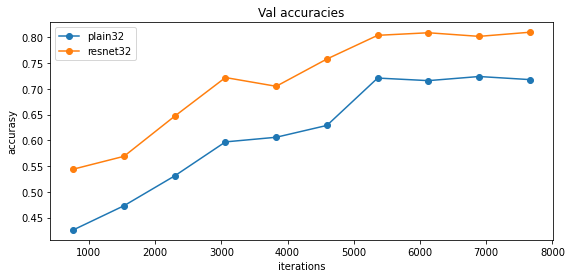

In [31]:
plt.title('Val accuracies')
for name in names:
    plt.plot(iter_history_dict[name], acc_history_dict[name], '-o')
plt.legend(names, loc='best')
plt.xlabel('iterations')
plt.ylabel('accurasy')
plt.gcf().set_size_inches(9, 4)
plt.show();

###Resdidual BottleNeck block
1. Spatial Batch normalization
2. ReLU
3. Convolutional layer with `Cout // 4` 1x1 filters, stride 2 if downsampling; otherwise stride 1
4. Spatial Batch normalization
5. ReLU
6. Convolutional layer with `Cout // 4` 3x3 filters, with zero-padding of 1
7. Spatial Batch normalization
8. ReLU
9. Convolutional layer with `Cout` 1x1 filters


In [75]:
class ResidualBottleneckBlock(nn.Module):
    def __init__(self, Cin, Cout, downsample=False):
        super().__init__()

        stride = 2 if downsample else 1
        self.block = nn.Sequential(
            nn.BatchNorm2d(Cin),
            nn.ReLU(),
            nn.Conv2d(Cin, Cout // 4, 1, stride=stride),
            nn.BatchNorm2d(Cout // 4),
            nn.ReLU(),
            nn.Conv2d(Cout//4, Cout // 4, 3, padding=1),
            nn.BatchNorm2d(Cout // 4),
            nn.ReLU(),
            nn.Conv2d(Cout//4, Cout, 1)
        )
        if not downsample:
            if Cin == Cout:
                self.shortcut = nn.Sequential(
                    nn.Identity()
                )
            else:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(Cin, Cout, 1)
                )
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(Cin, Cout, 1, stride = 2)
                )
    def forward(self, x):
        return self.block(x) + self.shortcut(x)

In [76]:
data = torch.zeros(2, 3, 5, 6)
model = ResidualBottleneckBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
model = ResidualBottleneckBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of ResidualBlock with downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!
The output of ResidualBlock with downsampling has a *correct* dimension!


### Checking architecture of ResNet

In [77]:
# example of specification
networks.update({
  'resnet47': {
    'block': ResidualBottleneckBlock,
    'stage_args': [
      (32, 32, 5, False),
      (32, 64, 5, True),
      (64, 128, 5, True),
    ],
  },
})

print(get_resnet('resnet47'))

ResNet(
  (cnn): Sequential(
    (0): ResNetStem(
      (net): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
    )
    (1): ResNetStage(
      (net): Sequential(
        (0): ResidualBottleneckBlock(
          (block): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (4): ReLU()
            (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (7): ReLU()
            (8): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (shortcut): Sequential(
            (0): Identity()
          )
        )
        (1): ResidualBottle